In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

data_path = os.path.join(os.getcwd())

In [2]:
# get top 50 stocks by market cap
top_stocks = pd.read_csv(os.path.join(data_path, 'top50stocks.csv'))
top_stocks.head()

,rank,name,symbol,market_cap
0,1,APPLE INC.,AAPL,2525.11
1,2,MICROSOFT CORPORATION,MSFT,2099.65
2,3,ALPHABET INC.,GOOG,1724.81
3,4,"AMAZON.COM, INC.",AMZN,1480.99
4,5,"TESLA, INC.",TSLA,822.00


In [88]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def get_stock_data(symbol, folder='Stocks'):
    """
    Gets stock data from Kaggle files
    """
    df = pd.read_csv(os.path.join(data_path, folder, f"{symbol}.us.txt"), index_col="Date", parse_dates=True)
    return df

transformers = {}

def get_scaled_stock_data(symbol, folder='Stocks'):
    """
    Gets scaled data from from a symbol
    """

    global transformers, scaler

    df = get_stock_data(symbol, folder)

    scaler = MinMaxScaler(feature_range=(0, 1))
    if 'OpenInt' in df.columns:
        df = df.drop('OpenInt', axis=1)
    scaled_data = scaler.fit_transform(df)

    cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    return scaler, scaled_data, cols


**Source**: A lot of this code comes from https://www.tensorflow.org/tutorials/structured_data/time_series

In [89]:
scaler, scaled_data, cols = get_scaled_stock_data('aapl')
df = pd.DataFrame(scaled_data, columns=cols)
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train, val_df=val, test_df=test,
               label_columns=['Open', 'High', 'Low', 'Close', 'Volume']):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

![Visualizing Example from below](images/Example1Generator.jpg)


In [90]:
# Example 1 from slide
window_generator = WindowGenerator(
                        input_width=6,
                        label_width=1,
                        shift=1)

In [91]:
generator = WindowGenerator(input_width=48, label_width=1, shift=1)
generator

Total window size: 49
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48]
Label column name(s): ['Open', 'High', 'Low', 'Close', 'Volume']

## Split Window

![Visualizing Example from below](images/Spliting.jpg)

In [92]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [93]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train[:generator.total_window_size]),
                           np.array(train[100:100+generator.total_window_size]),
                           np.array(train[200:200+generator.total_window_size]),
                           np.array(train[300:300+generator.total_window_size]),
                           np.array(train[400:400+generator.total_window_size]),
                           np.array(train[500:500+generator.total_window_size]),])

example_inputs, example_labels = generator.split_window(example_window)

generator.example = example_inputs, example_labels

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (6, 49, 5)
Inputs shape: (6, 48, 5)
Labels shape: (6, 1, 5)


**Notes**: (_, _, 5) -> The final dimension represents the [Open, High, Low, Close, Volume] dimension

In [94]:
generator.example = example_inputs, example_labels

def plot(self, model=None, plot_col='Close', max_subplots=6):
  inputs, labels = self.example
  plt.figure(figsize=(16, 12))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      # print(predictions.shape)
      # print(len(predictions.shape))
      if (len(predictions.shape) == 3):
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
      else:
        plt.scatter(self.label_indices, predictions[n, label_col_index],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

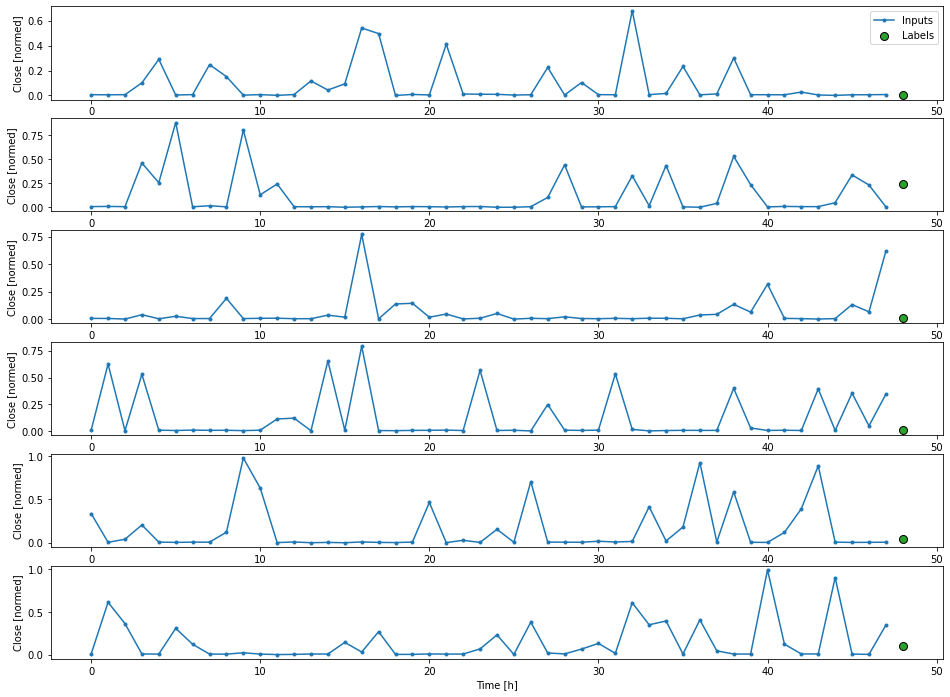

In [95]:
generator.plot(plot_col='Close')

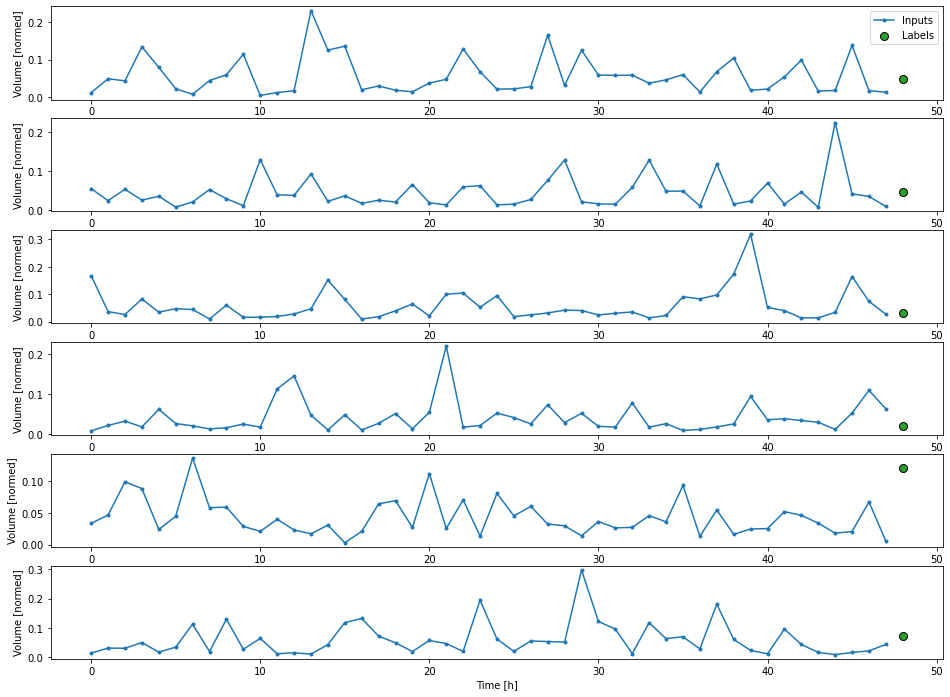

In [96]:
generator.plot(plot_col='Volume')

In [97]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=64,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [98]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [99]:
# generator = WindowGenerator(input_width=24, label_width=1, shift=1)
# generator

In [100]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                            patience=patience,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0000001)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=20,
                      validation_data=window.val,
                      callbacks=[early_stopping, learning_rate_reduction])
  return history

## Mean Absolute Percentage Error

`loss = 100 * mean(abs((y_true - y_pred) / y_true), axis=-1)`

# Dense Layers

In [39]:
model_1 = tf.keras.models.Sequential([
    # [batch, time, features] -> [batch, time*features]
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax'),
    tf.keras.layers.Reshape([1, -1])
])

compile_and_fit(model_1, generator)

Epoch 1/20
78/78 [==============================] - 1s 11ms/step - loss: 1.0541 - mean_absolute_error: 0.8405 - mean_absolute_percentage_error: 217.6419 - val_loss: 1.0599 - val_mean_absolute_error: 0.8310 - val_mean_absolute_percentage_error: 196.2400 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 1s 7ms/step - loss: 1.0356 - mean_absolute_error: 0.8345 - mean_absolute_percentage_error: 205.1576 - val_loss: 1.0581 - val_mean_absolute_error: 0.8298 - val_mean_absolute_percentage_error: 200.7717 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 1s 9ms/step - loss: 1.0247 - mean_absolute_error: 0.8301 - mean_absolute_percentage_error: 213.2703 - val_loss: 1.0583 - val_mean_absolute_error: 0.8290 - val_mean_absolute_percentage_error: 206.7664 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 1s 7ms/step - loss: 1.0155 - mean_absolute_error: 0.8261 - mean_absolute_percentage_error: 210.6326 - val_loss: 1.0580 - val_mean_absolute_error: 0.8283

In [42]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 240)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               30848     
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
 reshape_5 (Reshape)         (None, 1, 5)              0         
                                                                 
Total params: 31,493
Trainable params: 31,493
Non-trainable params: 0
_________________________________________________________________


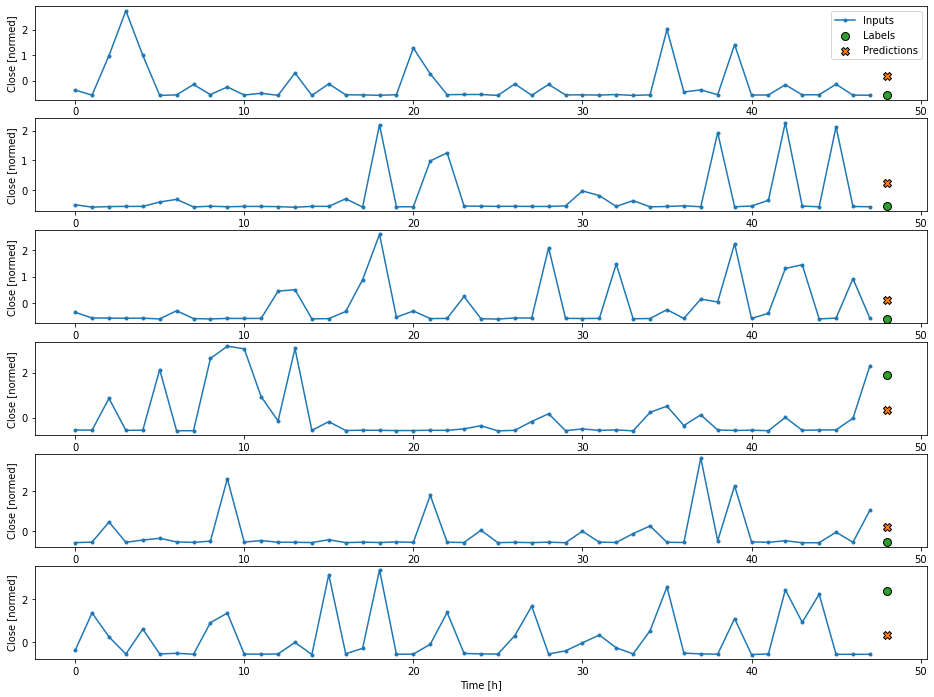

In [43]:
generator.plot(model=model_1)

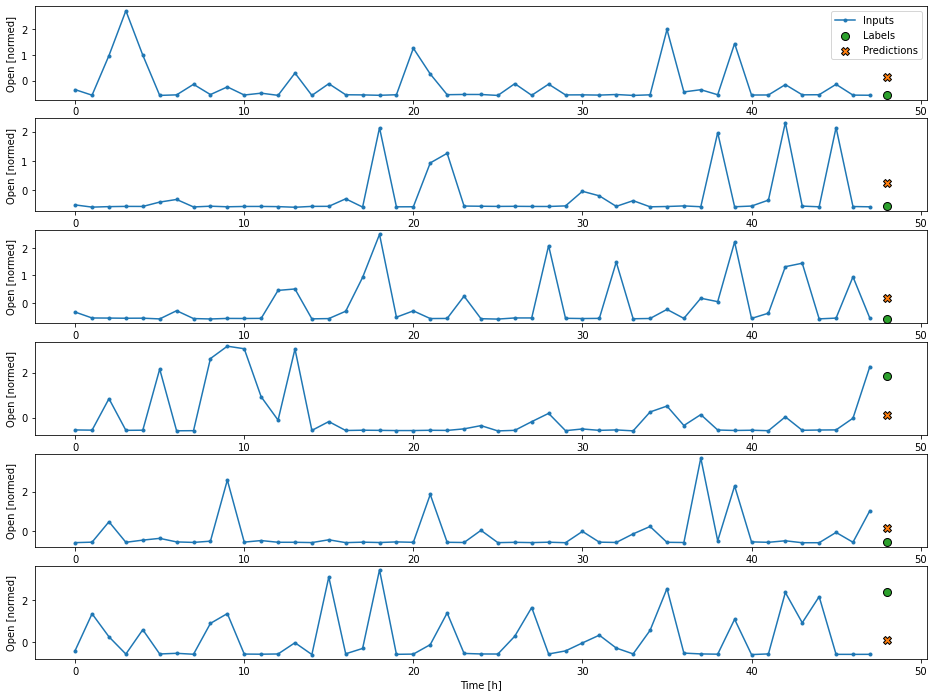

In [44]:
generator.plot(model=model_1, plot_col='Open')

## Many to One relationship

![Many to One Diagram](./images/ManyToOne2.jpg)

Inputs shape (batch, time, features): (64, 5, 5)
Labels shape (batch, time, features): (64, 1, 5)


Text(0.5, 1.0, 'Given 5 days of inputs, predict 1 hour into the future.')

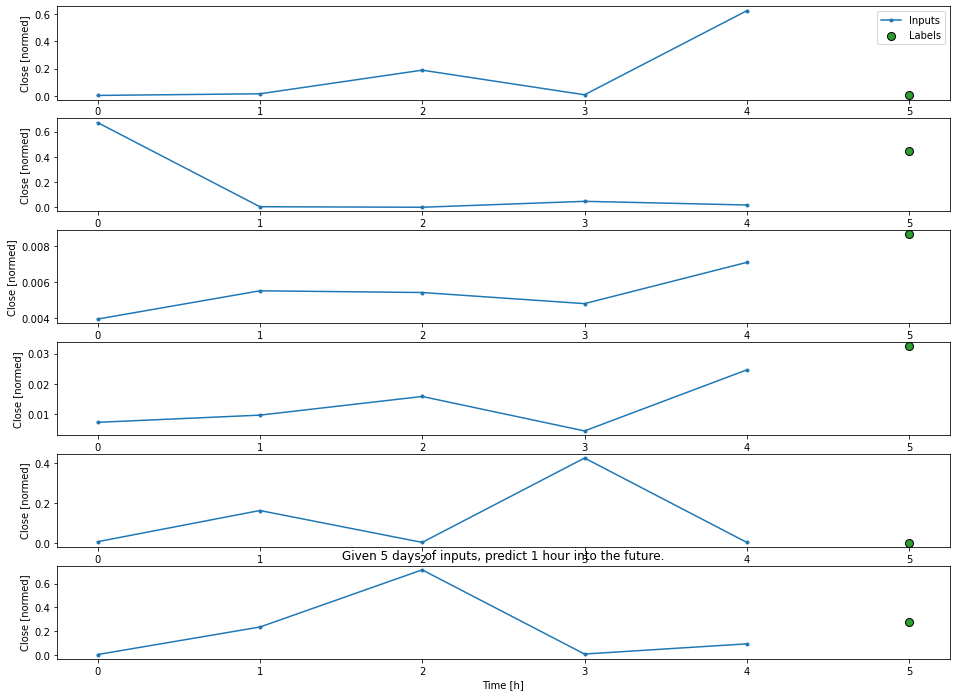

In [107]:
CONV_WIDTH = 5
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Open', 'High', 'Low', 'Close', 'Volume'])

for example_inputs, example_labels in conv_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

conv_window.example = example_inputs, example_labels

conv_window.plot()
plt.title("Given 5 days of inputs, predict 1 hour into the future.")

In [108]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='softmax'),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (64, 5, 5)
Output shape: (64, 1, 5)


### Multiple Dense Layers Visualization

https://www.youtube.com/watch?v=joA6fEAbAQc

In [109]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/20
79/79 [==============================] - 4s 44ms/step - loss: 0.0462 - mean_absolute_error: 0.1884 - mean_absolute_percentage_error: 55875.6523 - val_loss: 0.0435 - val_mean_absolute_error: 0.1836 - val_mean_absolute_percentage_error: 5468.4595 - lr: 0.0010
Epoch 2/20
79/79 [==============================] - 1s 14ms/step - loss: 0.0461 - mean_absolute_error: 0.1880 - mean_absolute_percentage_error: 53538.4453 - val_loss: 0.0434 - val_mean_absolute_error: 0.1841 - val_mean_absolute_percentage_error: 5421.8691 - lr: 0.0010
Epoch 3/20
79/79 [==============================] - 1s 6ms/step - loss: 0.0461 - mean_absolute_error: 0.1881 - mean_absolute_percentage_error: 53919.5195 - val_loss: 0.0434 - val_mean_absolute_error: 0.1838 - val_mean_absolute_percentage_error: 5447.7500 - lr: 0.0010
Epoch 4/20
79/79 [==============================] - ETA: 0s - loss: 0.0461 - mean_absolute_error: 0.1881 - mean_absolute_percentage_error: 54432.9141
Epoch 00004: ReduceLROnPlateau reducing lear

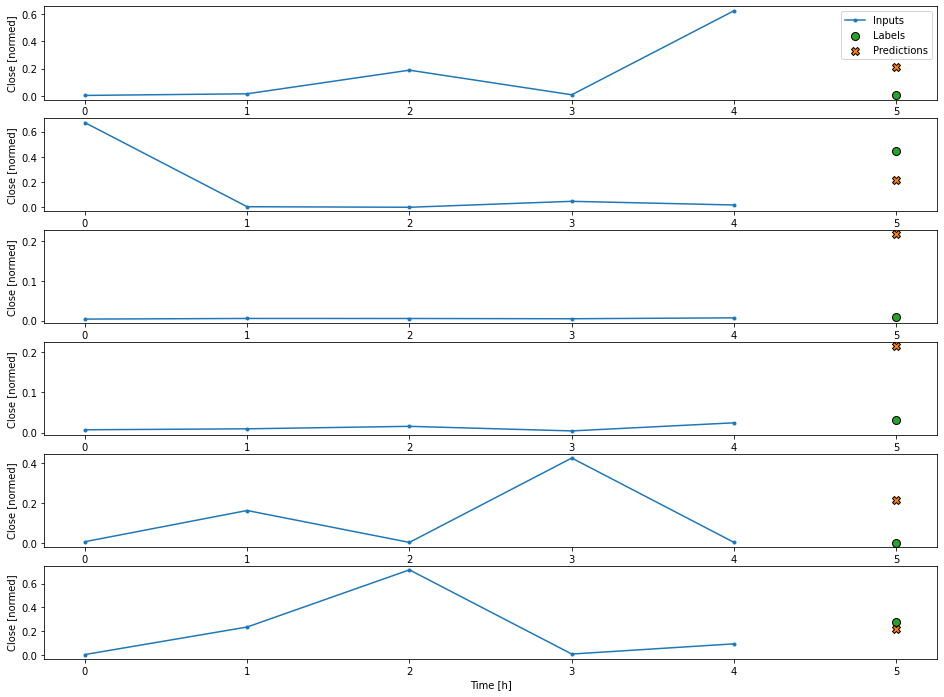

In [110]:
conv_window.plot(multi_step_dense)

In [111]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64*5, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.Dense(units=64*5, activation='relu'),
    tf.keras.layers.Dense(units=5),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (64, 5, 5)
Output shape: (64, 1, 5)


In [112]:
compile_and_fit(conv_model, conv_window)

Epoch 1/20
79/79 [==============================] - 3s 32ms/step - loss: 0.0393 - mean_absolute_error: 0.1354 - mean_absolute_percentage_error: 52105.9258 - val_loss: 0.0361 - val_mean_absolute_error: 0.1393 - val_mean_absolute_percentage_error: 3463.6724 - lr: 0.0010
Epoch 2/20
79/79 [==============================] - 3s 43ms/step - loss: 0.0385 - mean_absolute_error: 0.1369 - mean_absolute_percentage_error: 21842.9746 - val_loss: 0.0355 - val_mean_absolute_error: 0.1271 - val_mean_absolute_percentage_error: 2723.4436 - lr: 0.0010
Epoch 3/20
79/79 [==============================] - 3s 41ms/step - loss: 0.0383 - mean_absolute_error: 0.1355 - mean_absolute_percentage_error: 29726.6016 - val_loss: 0.0356 - val_mean_absolute_error: 0.1382 - val_mean_absolute_percentage_error: 3440.0898 - lr: 0.0010
Epoch 4/20
79/79 [==============================] - 3s 41ms/step - loss: 0.0383 - mean_absolute_error: 0.1366 - mean_absolute_percentage_error: 32261.9785 - val_loss: 0.0354 - val_mean_absolute

In [51]:
conv_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 320)            8320      
                                                                 
 dense_16 (Dense)            (None, 1, 320)            102720    
                                                                 
 dense_17 (Dense)            (None, 1, 5)              1605      
                                                                 
 reshape_7 (Reshape)         (None, 1, 5)              0         
                                                                 
Total params: 112,645
Trainable params: 112,645
Non-trainable params: 0
_________________________________________________________________


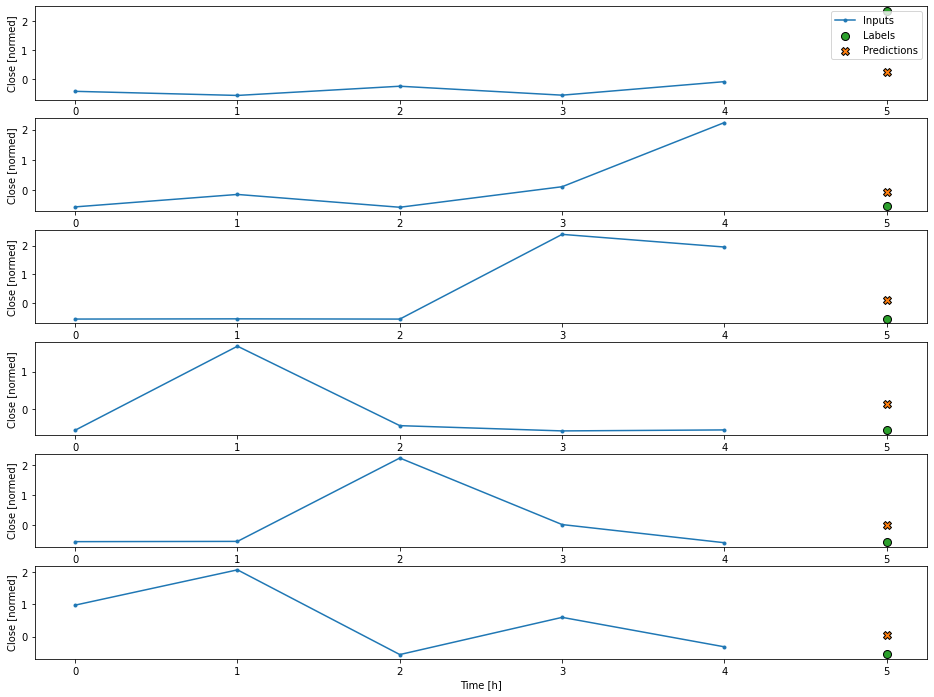

In [52]:
conv_window.plot(conv_model)

### Wider Window

In [113]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Add examples
for example_inputs, example_labels in wide_conv_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

wide_conv_window.example = example_inputs, example_labels

wide_conv_window

Inputs shape (batch, time, features): (64, 28, 5)
Labels shape (batch, time, features): (64, 24, 5)


Total window size: 29
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Label indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Label column name(s): ['Open', 'High', 'Low', 'Close', 'Volume']

In [114]:
conv_model = tf.keras.Sequential([
    # [batch, time, features] => [batch, features, filters]
    tf.keras.layers.Conv1D(filters=LABEL_WIDTH, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.Permute([2, 1]),
    tf.keras.layers.Dense(units=2048*5, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Reshape([LABEL_WIDTH, 5]),
])

compile_and_fit(conv_model, wide_conv_window)

Epoch 1/20
78/78 [==============================] - 3s 32ms/step - loss: 0.0348 - mean_absolute_error: 0.1272 - mean_absolute_percentage_error: 28259.4023 - val_loss: 0.0271 - val_mean_absolute_error: 0.1070 - val_mean_absolute_percentage_error: 2201.7468 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 1s 15ms/step - loss: 0.0243 - mean_absolute_error: 0.0988 - mean_absolute_percentage_error: 21705.4902 - val_loss: 0.0164 - val_mean_absolute_error: 0.0798 - val_mean_absolute_percentage_error: 1719.4210 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 5s 70ms/step - loss: 0.0146 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 12326.8799 - val_loss: 0.0115 - val_mean_absolute_error: 0.0630 - val_mean_absolute_percentage_error: 1248.4213 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 1s 12ms/step - loss: 0.0115 - mean_absolute_error: 0.0594 - mean_absolute_percentage_error: 13346.6846 - val_loss: 0.0101 - val_mean_absolute

In [115]:
conv_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 24, 24)            624       
                                                                 
 permute_9 (Permute)         (None, 24, 24)            0         
                                                                 
 dense_48 (Dense)            (None, 24, 10240)         256000    
                                                                 
 dense_49 (Dense)            (None, 24, 5)             51205     
                                                                 
 reshape_18 (Reshape)        (None, 24, 5)             0         
                                                                 
Total params: 307,829
Trainable params: 307,829
Non-trainable params: 0
_________________________________________________________________


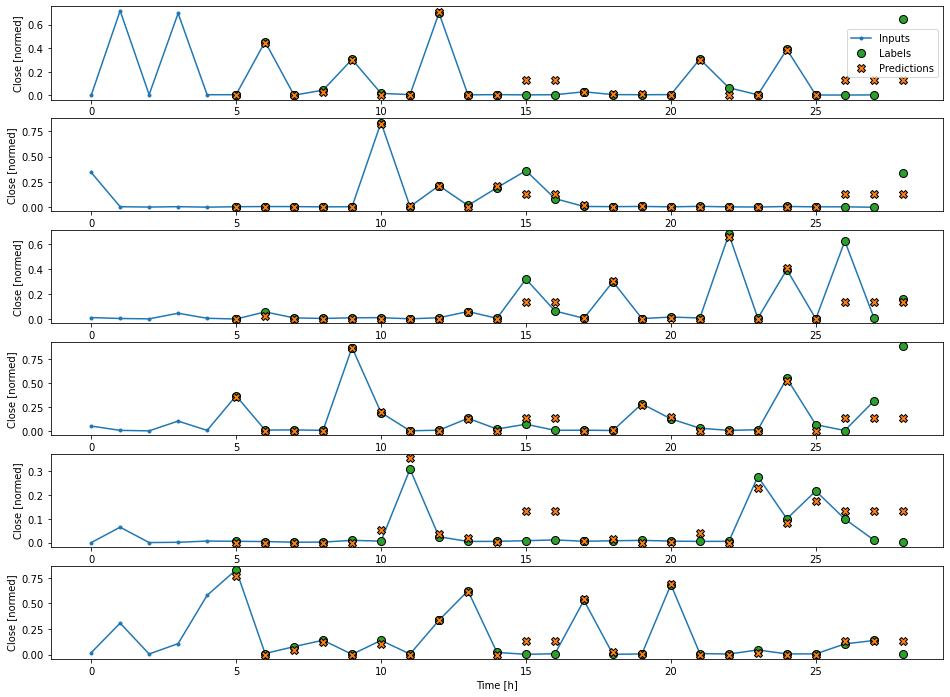

In [116]:
wide_conv_window.plot(conv_model)

**Note**: Look at how accurate these predictions are.

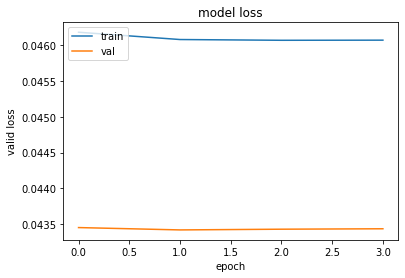

In [117]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Multi-Step

![Multi Step Diagram](./images/FuturePredictor.jpg)

In [118]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

multi_window.example = example_inputs, example_labels

# multi_window.plot(plot_col='Close')

Inputs shape (batch, time, features): (64, 24, 5)
Labels shape (batch, time, features): (64, 24, 5)


In [119]:
num_features = 5
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros(), activation='softmax'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/20
78/78 [==============================] - 3s 32ms/step - loss: 0.0498 - mean_absolute_error: 0.1062 - mean_absolute_percentage_error: 2221.4009 - val_loss: 0.0454 - val_mean_absolute_error: 0.1031 - val_mean_absolute_percentage_error: 224.4688 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 1s 11ms/step - loss: 0.0496 - mean_absolute_error: 0.1073 - mean_absolute_percentage_error: 2316.7739 - val_loss: 0.0453 - val_mean_absolute_error: 0.1042 - val_mean_absolute_percentage_error: 255.2056 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 2s 21ms/step - loss: 0.0496 - mean_absolute_error: 0.1077 - mean_absolute_percentage_error: 2331.5034 - val_loss: 0.0452 - val_mean_absolute_error: 0.1043 - val_mean_absolute_percentage_error: 258.4477 - lr: 0.0010
Epoch 4/20
77/78 [============================>.] - ETA: 0s - loss: 0.0495 - mean_absolute_error: 0.1078 - mean_absolute_percentage_error: 2390.2832
Epoch 00004: ReduceLROnPlateau reducing learning r

In [120]:
multi_linear_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 1, 5)              0         
                                                                 
 dense_50 (Dense)            (None, 1, 512)            3072      
                                                                 
 dense_51 (Dense)            (None, 1, 120)            61560     
                                                                 
 reshape_19 (Reshape)        (None, 24, 5)             0         
                                                                 
Total params: 64,632
Trainable params: 64,632
Non-trainable params: 0
_________________________________________________________________


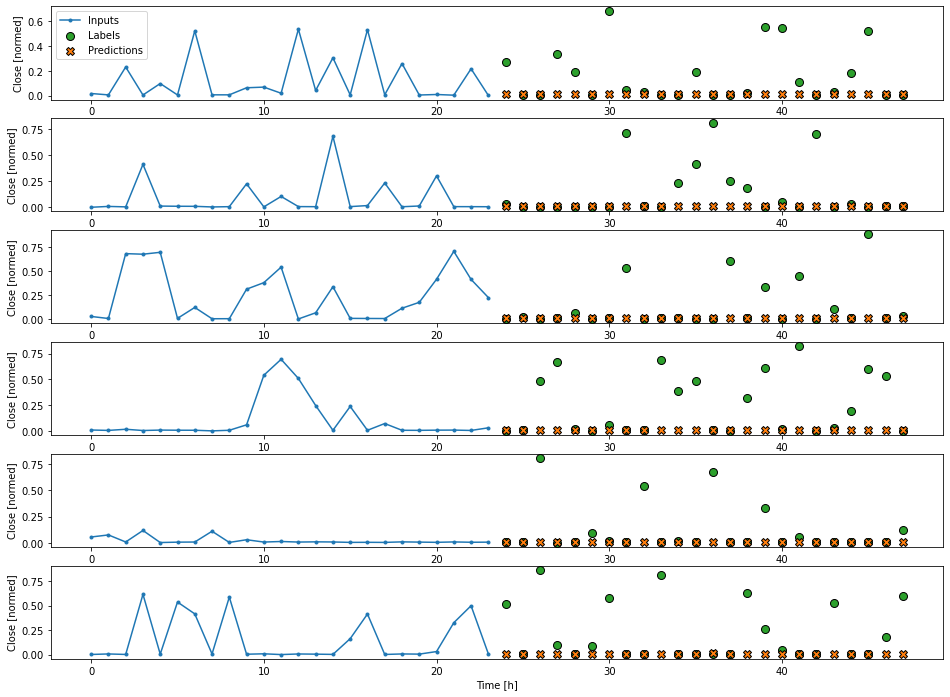

In [133]:
multi_window.plot(model=multi_linear_model)

In [122]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(1024, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros(), activation='softmax'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/20
78/78 [==============================] - 4s 41ms/step - loss: 0.0497 - mean_absolute_error: 0.1066 - mean_absolute_percentage_error: 2264.5881 - val_loss: 0.0453 - val_mean_absolute_error: 0.1042 - val_mean_absolute_percentage_error: 256.0738 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 3s 41ms/step - loss: 0.0496 - mean_absolute_error: 0.1078 - mean_absolute_percentage_error: 2397.3308 - val_loss: 0.0452 - val_mean_absolute_error: 0.1043 - val_mean_absolute_percentage_error: 258.5832 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 3s 39ms/step - loss: 0.0496 - mean_absolute_error: 0.1078 - mean_absolute_percentage_error: 2480.8535 - val_loss: 0.0452 - val_mean_absolute_error: 0.1043 - val_mean_absolute_percentage_error: 258.5754 - lr: 0.0010
Epoch 4/20
76/78 [============================>.] - ETA: 0s - loss: 0.0496 - mean_absolute_error: 0.1079 - mean_absolute_percentage_error: 2582.4590
Epoch 00004: ReduceLROnPlateau reducing learning r

In [123]:
multi_conv_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 24, 5)             0         
                                                                 
 conv1d_11 (Conv1D)          (None, 1, 1024)           123904    
                                                                 
 dense_52 (Dense)            (None, 1, 120)            123000    
                                                                 
 reshape_20 (Reshape)        (None, 24, 5)             0         
                                                                 
Total params: 246,904
Trainable params: 246,904
Non-trainable params: 0
_________________________________________________________________


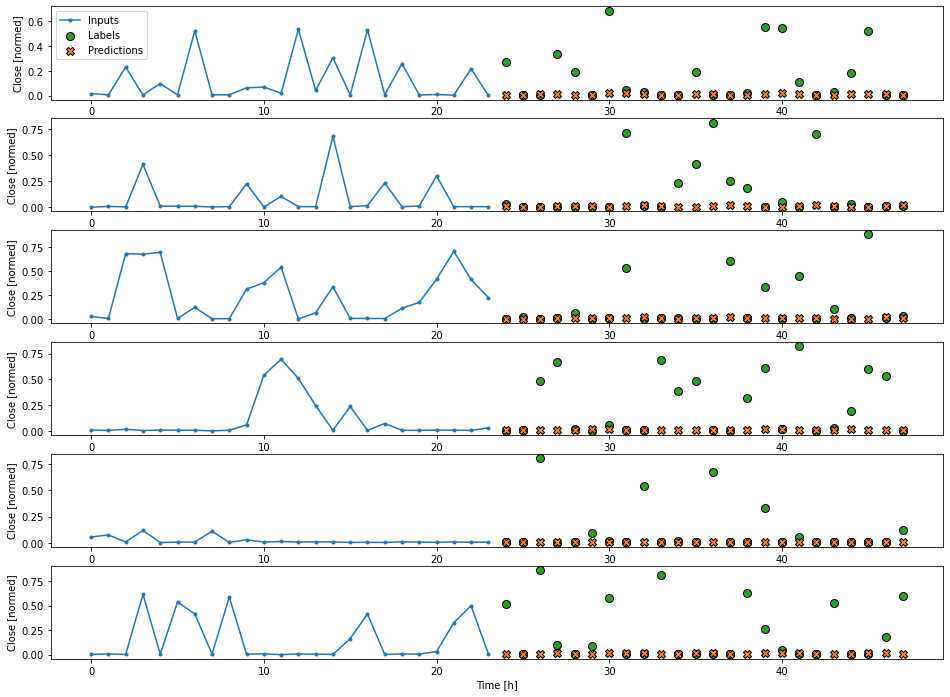

In [124]:
multi_window.plot(model=multi_conv_model)

In [128]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, features, time]
    tf.keras.layers.Permute([2,1]),
    tf.keras.layers.LSTM(256, return_sequences=True, use_bias=True),
    # Shape => [batch, features, time] => [batch, time, features]
    tf.keras.layers.Dense(24),
    tf.keras.layers.Permute([2,1]),
])

compile_and_fit(lstm_model, multi_window)

Epoch 1/20
78/78 [==============================] - 7s 68ms/step - loss: 0.0405 - mean_absolute_error: 0.1326 - mean_absolute_percentage_error: 30800.3418 - val_loss: 0.0356 - val_mean_absolute_error: 0.1320 - val_mean_absolute_percentage_error: 2966.7913 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 22s 283ms/step - loss: 0.0388 - mean_absolute_error: 0.1364 - mean_absolute_percentage_error: 35409.0547 - val_loss: 0.0354 - val_mean_absolute_error: 0.1332 - val_mean_absolute_percentage_error: 3027.3879 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 19s 246ms/step - loss: 0.0386 - mean_absolute_error: 0.1368 - mean_absolute_percentage_error: 35176.8125 - val_loss: 0.0354 - val_mean_absolute_error: 0.1331 - val_mean_absolute_percentage_error: 3025.0444 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 3s 44ms/step - loss: 0.0385 - mean_absolute_error: 0.1369 - mean_absolute_percentage_error: 35255.6758 - val_loss: 0.0353 - val_mean_abso

In [130]:
lstm_model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_12 (Permute)        (None, 5, 24)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 256)            287744    
                                                                 
 dense_55 (Dense)            (None, 5, 24)             6168      
                                                                 
 permute_13 (Permute)        (None, 24, 5)             0         
                                                                 
Total params: 293,912
Trainable params: 293,912
Non-trainable params: 0
_________________________________________________________________


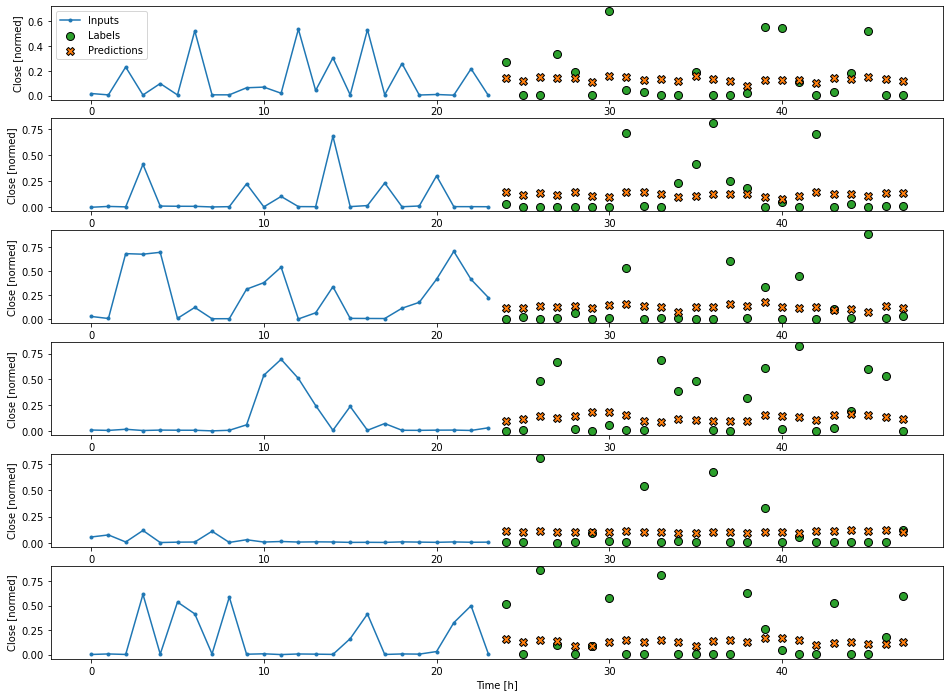

In [131]:
multi_window.plot(model=lstm_model)

In [134]:
lstm_model_2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, features, time]
    tf.keras.layers.Permute([2,1]),
    tf.keras.layers.LSTM(256, return_sequences=True, use_bias=True),
    # Shape => [batch, features, time] => [batch, time, features]
    tf.keras.layers.Dense(24),
    tf.keras.layers.Permute([2,1]),
])

compile_and_fit(lstm_model_2, wide_conv_window)

Epoch 1/20
78/78 [==============================] - 4s 28ms/step - loss: 0.0217 - mean_absolute_error: 0.0940 - mean_absolute_percentage_error: 24579.2148 - val_loss: 0.0094 - val_mean_absolute_error: 0.0644 - val_mean_absolute_percentage_error: 1247.9019 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 1s 6ms/step - loss: 0.0053 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 12634.8711 - val_loss: 0.0026 - val_mean_absolute_error: 0.0255 - val_mean_absolute_percentage_error: 526.2288 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 2s 23ms/step - loss: 0.0024 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 9779.7861 - val_loss: 0.0020 - val_mean_absolute_error: 0.0189 - val_mean_absolute_percentage_error: 400.5024 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 2s 25ms/step - loss: 0.0020 - mean_absolute_error: 0.0172 - mean_absolute_percentage_error: 6748.1890 - val_loss: 0.0017 - val_mean_absolute_erro

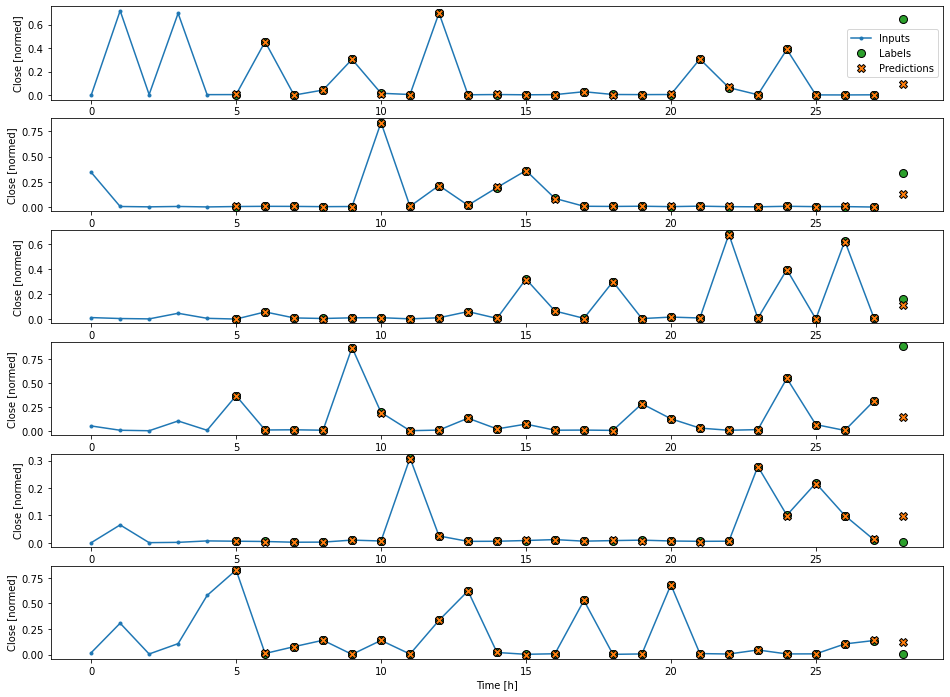

In [135]:
wide_conv_window.plot(model=lstm_model_2)

# Extra Code Snippets

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10) # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0000001)

callbacks = [earlystop, learning_rate_reduction]